In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn import preprocessing
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

In [4]:
# Read the JSON file with line-separated JSON objects
df = pd.read_json('News_Category_Dataset_v3.json', lines=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [5]:
# Drop link and date which would not be used as a feature, and combine headline and short_description into a column
df['text'] = df['headline'] + ' ' + df['short_description']
df = df.drop(columns=["link", "date", "headline", "short_description", "authors"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   category  209527 non-null  object
 1   text      209527 non-null  object
dtypes: object(2)
memory usage: 3.2+ MB


In [6]:
category_mapping = {
    'U.S. NEWS': 'News',
    'WORLD NEWS': 'News',
    'POLITICS': 'News',
    'SCIENCE': 'Education',
    'EDUCATION': 'Education',
    'ENVIRONMENT': 'Environment',
    'CRIME': 'News',
    'BUSINESS': 'Business',
    'TECH': 'Business',
    'SPORTS': 'Entertainment',
    'COMEDY': 'Entertainment',
    'ENTERTAINMENT': 'Entertainment',
    'CULTURE & ARTS': 'Culture & Arts',
    'ARTS & CULTURE': 'Culture & Arts',
    'STYLE & BEAUTY': 'Lifestyle',
    'FOOD & DRINK': 'Lifestyle',
    'HEALTHY LIVING': 'Lifestyle',
    'WELLNESS': 'Lifestyle',
    'PARENTING': 'Lifestyle',
    'PARENTS': 'Lifestyle',
    'HOME & LIVING': 'Lifestyle',
    'QUEER VOICES': 'Society',
    'LATINO VOICES': 'Society',
    'BLACK VOICES': 'Society',
    'WOMEN': 'Society',
    'TRAVEL': 'Lifestyle',
    'MONEY': 'Business',
    'RELIGION': 'Society',
    'IMPACT': 'News',
    'GOOD NEWS': 'News',
    'WORLDPOST': 'News',
    'THE WORLDPOST': 'News',
    'MEDIA': 'News',
    'STYLE': 'Lifestyle',
    'GREEN': 'Environment',
    'TASTE': 'Lifestyle',
    'FIFTY': 'Culture & Arts',
    'ARTS': 'Culture & Arts',
    'DIVORCE': 'Lifestyle',
    'WEIRD NEWS': 'News',
    'COLLEGE': 'Education', 
    'WEDDINGS': 'Lifestyle',
}

# Map the categories in the DataFrame
df['reduced_category'] = df['category'].map(category_mapping).fillna(df['category'])

In [7]:
# EDA: Check for missing values
missing_values = df.isnull().sum()

# Display missing values count per column
print("Number of missing values:", missing_values, sep="\n")

Number of missing values:
category            0
text                0
reduced_category    0
dtype: int64


In [8]:
# EDA: Check for duplicates
duplicate_rows = df.duplicated()

# Count how many duplicates there are
num_duplicates = duplicate_rows.sum()

print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 471


In [9]:
# EDA: Remove duplicates
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 209056 entries, 0 to 209526
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   category          209056 non-null  object
 1   text              209056 non-null  object
 2   reduced_category  209056 non-null  object
dtypes: object(3)
memory usage: 6.4+ MB


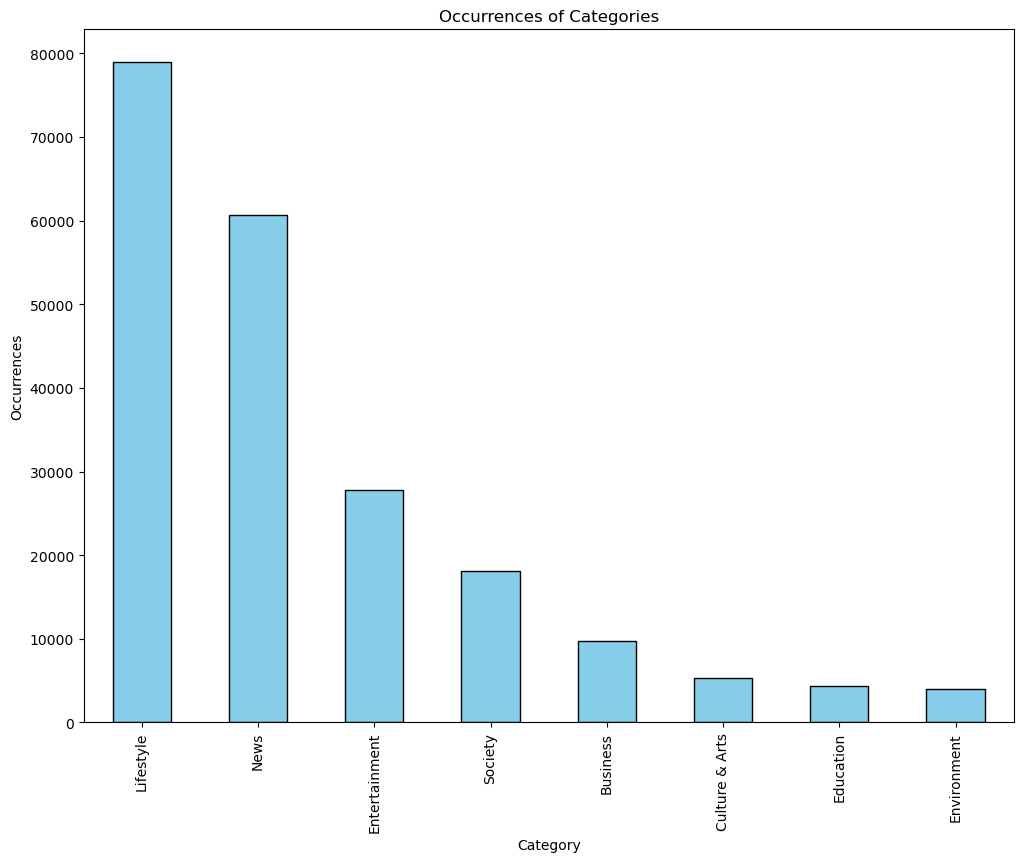

In [10]:
# EDA: Distribution of categories

# Count occurrences of each category
category_counts = df['reduced_category'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(12, 9))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Category')
plt.ylabel('Occurrences')
plt.title('Occurrences of Categories')

# Display the plot
plt.show()

In [73]:
# EDA: Latent Dirichlet Allocation to identify top words that are associated with that particular category

# Define text preprocessing function
def preprocess_text_nltk(text):
    # Lowercase, punctuation removal, tokenization, and stopword removal
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and not word.isdigit()]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Return the preprocessed text
    return " ".join(tokens)

# Define function that applies LDA and displays  top words for each category
def fit_lda(df, top_n_words):
    # Define categories for function to iterate through
    categories = df["reduced_category"].unique() 

    # Store results to transfer into dataframe
    results = []
    
    for category in categories:
        # Filter the dataframe by category
        category_df = df[df["reduced_category"] == category]
        
        # Vectorize the text using TfidfVectorizer
        vectorizer = TfidfVectorizer(stop_words='english')
        X = vectorizer.fit_transform(category_df["processed_text"])
        
        # Fit the LDA model for this category
        lda = LatentDirichletAllocation(n_components=1, random_state=1424)
        lda.fit(X)
        
        # Get the top words for the single topic
        terms = vectorizer.get_feature_names_out()
        top_words_idx = lda.components_[0].argsort()[-top_n_words:][::-1]  # Top 10 words for the topic
        top_words = [terms[i] for i in top_words_idx]
        
        # Dynamically display the top words for the category
        results.append([category, top_words])

    # Create dataframe from the results list
    lda_results_df = pd.DataFrame(results, columns=['Category', 'Top Words'])
    
    return lda_results_df

# Apply the functions
df['processed_text'] = df['text'].apply(preprocess_text)
lda_results = fit_lda(df, 10)

# Drop TF-IDF processed text since we are using BERT for subsequent analysis
df = df.drop(columns=["processed_text"])

# Print out the results
pd.set_option('display.max_colwidth', None)
lda_results

,Category,Top Words
0,News,"[trump, donald, new, president, said, people, says, trumps, gop, house]"
1,Entertainment,"[new, trump, like, donald, star, video, time, says, game, watch]"
2,Lifestyle,"[photos, new, day, time, like, make, life, best, people, want]"
3,Culture & Arts,"[art, new, artist, photos, life, like, world, years, time, people]"
4,Business,"[new, business, people, time, money, apple, company, women, make, work]"
5,Environment,"[climate, change, week, new, animal, photos, world, dog, people, water]"
6,Education,"[college, new, students, education, school, scientists, space, science, time, like]"
7,Society,"[gay, women, black, new, people, like, love, day, time, trump]"


In [80]:
# Filter rows that belong to the 'Entertainment' category and contain 'Trump' in the 'text' column
entertainment_trump_rows = df[(df['reduced_category'] == 'Entertainment') & df['text'].str.contains('trump', case=False, na=False)]

# Display the resulting rows
entertainment_trump_rows.head()

,category,text,reduced_category
4187,BLACK VOICES,Dem Rep Warns Trump's Kenosha Visit Is Meant To 'Agitate' And 'Make Things Worse' Rep. Karen Bass said Sunday that Trump's scheduled visit to Wisconsin in the wake of protests against police brutality is meant to cause harm.,Society
7353,BLACK VOICES,"Majority Of Clemson’s Black Players Reportedly Skipped Donald Trump's Fast-Food Buffet Some of the team's black athletes cited Trump's ""divisive politics"" and ""racism"" as reasons for not attending, according to The Root.",Society
7651,RELIGION,"This Nun Tweets A Daily Prayer To Trump For Him To 'Grow In Humility' ""It’s been the hardest spiritual practice I’ve ever committed to,"" Sister Susan Francois told The New York Times.",Society
7831,WOMEN,Trump’s False Narrative On Assault And Jim Acosta Is Convenient For Him And No One Else The White House outright lied about the CNN reporter “placing his hands on a young woman” and barred him from future press conferences.,Society
8453,RELIGION,"With Brett Kavanaugh's Nomination, Trump Again Privileges Conservative Christians Progressive Christians fear that a right-tilting Supreme Court could cause the country to retreat from progress on ensuring equality for all.",Society


In [17]:
# Initialize models
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Initialize GPU hardware accleration
device = torch.device("mps")
model.to(device)

def get_bert_embeddings(text):
    # Tokenize and encode the text
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    
    # Move inputs to the same device as the model
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    # Forward pass through BERT
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extract embeddings from the last hidden state (CLS token embedding)
    embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # Move to CPU before converting to numpy
    
    return embeddings

# Use tqdm to show progress bar
df['embeddings'] = [get_bert_embeddings(text).flatten() for text in tqdm(df['text'], desc="Processing Text to BERT Embeddings")]

Processing Text to BERT Embeddings: 100%|█| 209056/209056 [1:13:24<00:00, 47.46it/


In [18]:
# Export as parquet file to save computational cost
df.to_parquet('bert_transformed.parquet')